In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from tyssue import Sheet
from tyssue import PlanarGeometry
from tyssue.generation import generate_ring
from tyssue import config
from tyssue.draw import sheet_view


import ipyvolume as ipv
ipv.clear()

CGAL-based mesh generation utilities not found, you may need to install CGAL and build from source
C++ extensions are not available for this version


In [2]:
from tyssue import SheetGeometry
nx=20
ny=20

sheet_3d = Sheet.planar_sheet_3d(
    'sheet', nx=nx, ny=ny, distx=1, disty=1, noise=0.1
)
to_cut = sheet_3d.cut_out([(0.1, nx), (0.1, ny)])
sheet_3d.remove(to_cut, trim_borders=True)
sheet_3d.sanitize(trim_borders=True)
SheetGeometry.update_all(sheet_3d)

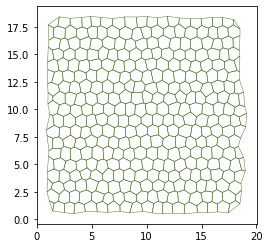

In [3]:
fig, ax = sheet_view(sheet_3d)

In [4]:
from tyssue import Monolayer, MonolayerGeometry, ClosedMonolayerGeometry
from tyssue.generation import extrude

extruded = extrude(sheet_3d.datasets, method='translation')
specs = config.geometry.bulk_spec()
monolayer = Monolayer('mono', extruded, specs)
MonolayerGeometry.update_all(monolayer)
MonolayerGeometry.center(monolayer)

In [5]:
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D")
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [6]:
from tyssue.dynamics import model_factory, effectors, units
from tyssue.dynamics.effectors import AbstractEffector, height_grad
from tyssue.utils.utils import to_nd
class RadialTension2(AbstractEffector):
    """
    Apply a tension perpendicular to a face.
    """

    dimensions = units.line_tension
    magnitude = "radial_tension"
    label = "Apical basal tension"
    element = "face"
    specs = {"face": {"height": 1.0, "radial_tension": 1.0}}

    @staticmethod
    def energy(eptm):
        return eptm.face_df.eval("height * radial_tension")

    @staticmethod
    def gradient(eptm):
        upcast_tension = eptm.upcast_face(
            eptm.face_df.eval("radial_tension / num_sides")
        )

        upcast_height = eptm.upcast_srce(height_grad(eptm))
        upcast_height['x']=1
        upcast_height['y']=1
        upcast_height['z']=1
        grad_srce = to_nd(upcast_tension, 3) * upcast_height
        grad_srce.columns = ["g" + u for u in eptm.coords]
        return grad_srce / 2, grad_srce / 2
    
model = model_factory(
    [
        effectors.FaceAreaElasticity,
        RadialTension2,
    ])

specs = {
    'edge': {
        'is_active': 1,
        'line_tension': 0.12,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0
    },
   'face': {
       'area_elasticity': 1.0,
       'contractility': 0.04,
       'is_alive': 1,
       'prefered_area': 1.0},
   'settings': {
       'grad_norm_factor': 1.0,
       'nrj_norm_factor': 1.0
   },
   'vert': {
       'is_active': 1
   }
}


# Update the specs (adds / changes the values in the dataframes' columns)
monolayer.update_specs(specs)
# monolayer.specs
monolayer.face_df['radial_tension']=0

In [7]:
from tyssue.solvers import QSSolver
solver = QSSolver()
geom = MonolayerGeometry
res = solver.find_energy_min(monolayer, geom, model)

collision solver could not be imported You may need to install CGAL and re-install tyssue


TypeError: unsupported operand type(s) for *: 'object' and 'int64'

In [ ]:
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D")
fig

In [ ]:
border_cell = monolayer.cell_df[monolayer.cell_df['num_faces']<7].index.to_numpy()
border_face = np.unique(monolayer.edge_df[monolayer.edge_df['cell'].isin(border_cell)]['face'].to_numpy())
apical_border_face = monolayer.face_df.loc[border_face][monolayer.face_df.loc[border_face]['segment']=='apical'].index.to_numpy()
basal_border_face = monolayer.face_df.loc[border_face][monolayer.face_df.loc[border_face]['segment']=='basal'].index.to_numpy()
monolayer.face_df.loc[monolayer.face_df[monolayer.face_df['segment']=='apical']['height'].index]['height']=4

monolayer.face_df.loc[apical_border_face, 'radial_tension'] = 20
monolayer.face_df.loc[basal_border_face, 'radial_tension'] = 20

In [ ]:
inside_cell = monolayer.cell_df[monolayer.cell_df['num_faces']>=7].index.to_numpy()
inside_face = np.unique(monolayer.edge_df[monolayer.edge_df['cell'].isin(inside_cell)]['face'].to_numpy())
apical_inside_face = monolayer.face_df.loc[inside_face][monolayer.face_df.loc[inside_face]['segment']=='apical'].index.to_numpy()
basal_inside_face = monolayer.face_df.loc[inside_face][monolayer.face_df.loc[inside_face]['segment']=='basal'].index.to_numpy()
monolayer.face_df.loc[monolayer.face_df[monolayer.face_df['segment']=='apical']['height'].index]['height']=4

monolayer.face_df.loc[apical_inside_face, 'radial_tension'] = -5
monolayer.face_df.loc[basal_inside_face, 'radial_tension'] = -5

In [ ]:
res = solver.find_energy_min(monolayer, geom, model)

In [ ]:
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D")
fig

In [ ]:
from tyssue.draw.plt_draw import plot_forces

plot_forces(monolayer, geom, model, list('xz'), 1, ax=None, approx_grad=None)
